## Behavioural Cloning 
This notebook includes Data visualization for the Udacity Self-Driving Car Program's Behavioual Cloning project.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import pprint
import imageio
import cv2

In [2]:
# INPUT DATA
training_data_directory = './data/'
training_data_filename = 'driving_log.csv'
training_datafile = training_data_directory+training_data_filename

# Import data
drive_data = []
with open(training_datafile) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        drive_data.append(line)
variable_names = drive_data[0]
drive_data = drive_data[1:] # Remove Header Row
Ndata = len(drive_data)

# Train, Validation, Test
val_pct = 0.2
test_pct = 0.1

# Split Data into Train, Validation and Test
from sklearn.model_selection import train_test_split
split_data, test_data = train_test_split(drive_data, test_size = test_pct, random_state = 42)
training_data, validation_data = train_test_split(split_data, test_size = val_pct, random_state = 54)

# Data Sizes
Ntrain = len(training_data)
Ntest = len(test_data)
Nval = len(validation_data)

print('-- TRAINING DATA --')
print(('\tSize of Training Set: %d')%(Ntrain))
print('\tCategoriges:')
print('\t' + str(variable_names))
print('-- VALIDATION DATA --')
print(('\tSize of Training Set: %d')%(Nval))
print('-- TEST DATA --')
print(('\tSize of Training Set: %d')%(Ntest))

-- TRAINING DATA --
	Size of Training Set: 5785
	Categoriges:
	['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
-- VALIDATION DATA --
	Size of Training Set: 1447
-- TEST DATA --
	Size of Training Set: 804


In [3]:
# Ensure consistent data
assert(validation_data[0][0] == 'IMG/center_2016_12_01_13_44_01_013.jpg')

Text(0,0.5,'Steering Command')

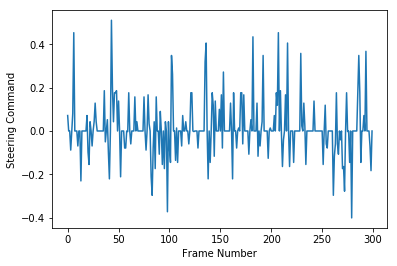

In [4]:
# Visualize Steering Signal Range
steering_data = np.array([float(row[3]) for row in training_data[1:]])
plt.plot(steering_data[0:300])
plt.xlabel('Frame Number')
plt.ylabel('Steering Command')

IMG/center_2016_12_01_13_38_21_342.jpg
Image Size:  (160, 320, 3)
['steering', 'throttle', 'brake', 'speed']
[' 0', ' 0.9855326', ' 0', ' 30.18664']


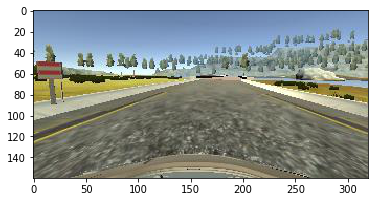

In [5]:
# Visualize Training Data
iData = np.random.randint(Ntrain)

# Data row
datarows = training_data[iData]
center_image_path = datarows[0]
print(center_image_path)

# import file
center_image = imageio.imread(training_data_directory+center_image_path)
plt.imshow(center_image)

# Image Dimensions
image_size = center_image.shape
print('Image Size: ',image_size)

# Measurement Data
print(variable_names[3:])
print(datarows[3:])

steering_measurement = datarows[3]

In [6]:
# Data generator for the Center Camera Channel
def centerCameraBatch(data,batchsize = 128):
    # Batch Data Generator for Nbatch
    Ndata = len(data)
    Nbatch = int(np.ceil(Ndata/batchsize))
    
    # Measurements
    for ibatch in range(Nbatch):
        X = []
        y = []
        if ibatch == Nbatch-1:
            # Last batch
            batch_index = (ibatch*batchsize, Ndata)
        else:
            batch_index = (ibatch*batchsize, (ibatch+1)*batchsize)
        for idx in np.arange(batch_index[0],batch_index[1]):
            image_file = data[idx][0]
            image = imageio.imread(training_data_directory+image_file)
            X.append(image)
            y.append(float(data[idx][3]))
        yield np.array(X), np.array(y)
    return 0

0 : [ 0.          0.07132844  0.          0.         -0.08824026  0.
  0.08089697  0.4540697   0.          0.          0.         -0.06925154]


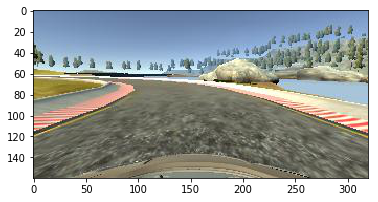

1 : [ 0.          0.         -0.2306556   0.          0.          0.
  0.          0.          0.07132844 -0.09773462 -0.1547008   0.04262284]


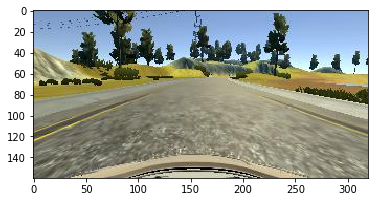

2 : [ 0.         -0.06925154  0.          0.04262284  0.1287396   0.04262284
  0.          0.          0.          0.          0.          0.        ]


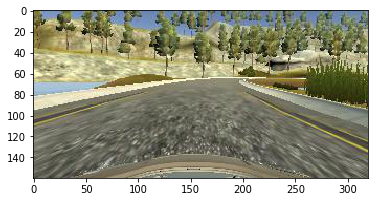

3 : [ 0.          0.1861508  -0.05026283  0.          0.05219137 -0.09773462
 -0.2211613   0.          0.5114809   0.1957194   0.04262284  0.1765823 ]


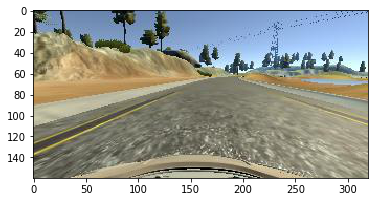

4 : [0.1765823 0.1861508]


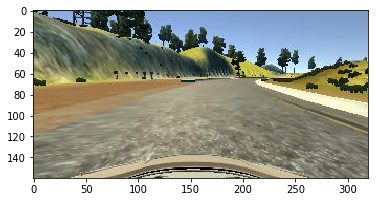

Data Shape: (2, 160, 320, 3)
Label Shape: (2,)


In [7]:
# Test Data Generator
batch_size = 12
datagen = centerCameraBatch(training_data[:50],batch_size)
ii = 0
for X_batch, y_batch in datagen:
    print(ii,':', y_batch)
    plt.imshow(X_batch[-1])
    plt.show()
    ii += 1
    
# Data Generator
print('Data Shape:', X_batch.shape)
print('Label Shape:', y_batch.shape)

In [18]:
print(image_size)

(160, 320, 3)


In [21]:
# Experiment loading a Pre-trained Model
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
import numpy as np

base_model = VGG19(weights='imagenet', include_top=False, input_shape=image_size)
# base_model = InceptionV3(include_top=False, weights='imagenet',\
#                           input_shape=image_size)
print(base_model)

In [22]:
for layer in base_model.layers:
    print(layer.name, layer.input_shape, layer.output_shape)
    
# Model Checking
assert(base_model.layers[0].input_shape[1:] == image_size)
Num_BASE_layers = len(base_model.layers)
print('Base Model Layers:', Num_BASE_layers)

input_7 (None, 160, 320, 3) (None, 160, 320, 3)
block1_conv1 (None, 160, 320, 3) (None, 160, 320, 64)
block1_conv2 (None, 160, 320, 64) (None, 160, 320, 64)
block1_pool (None, 160, 320, 64) (None, 80, 160, 64)
block2_conv1 (None, 80, 160, 64) (None, 80, 160, 128)
block2_conv2 (None, 80, 160, 128) (None, 80, 160, 128)
block2_pool (None, 80, 160, 128) (None, 40, 80, 128)
block3_conv1 (None, 40, 80, 128) (None, 40, 80, 256)
block3_conv2 (None, 40, 80, 256) (None, 40, 80, 256)
block3_conv3 (None, 40, 80, 256) (None, 40, 80, 256)
block3_conv4 (None, 40, 80, 256) (None, 40, 80, 256)
block3_pool (None, 40, 80, 256) (None, 20, 40, 256)
block4_conv1 (None, 20, 40, 256) (None, 20, 40, 512)
block4_conv2 (None, 20, 40, 512) (None, 20, 40, 512)
block4_conv3 (None, 20, 40, 512) (None, 20, 40, 512)
block4_conv4 (None, 20, 40, 512) (None, 20, 40, 512)
block4_pool (None, 20, 40, 512) (None, 10, 20, 512)
block5_conv1 (None, 10, 20, 512) (None, 10, 20, 512)
block5_conv2 (None, 10, 20, 512) (None, 10, 20,

In [ ]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Flatten

# Output Network (2 Dense Layers)
out_network_input = base_model.output_shape
print('Input Network Shape:',out_network_input)

outut_variables = 1;
output_network_filters = 128
x = Conv2D(output_network_filters,(1,1), activation='relu')(base_model.output)
x = GlobalAveragePooling2D()(x)

# Fully-connected Dense layer
x = Dense(64, activation='relu')(x)

# Linear Prediction layer
predictions = Dense(outut_variables, activation='linear')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Train only the output layers (which were randomly initialized)
# i.e. freeze all convolutional VGG19 layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='mean_squared_error')

# train the model on the new data for a few epochs
EPOCHS = 5
N_batch = 32
Ntrain_per_epoch = np.ceil(Ntrain/N_batch)
Nval_per_epoch = np.ceil(Nval/N_batch)


training_generator = centerCameraBatch(training_data,N_batch)
validation_generator = centerCameraBatch(validation_data,N_batch)
test_generator = centerCameraBatch(validation_data,N_batch)

# Fit Modelo
model.fit_generator(training_generator,\
                    steps_per_epoch = Ntrain_per_epoch,\
                    epochs = EPOCHS,\
                    validation_data = validation_generator,\
                    validation_steps = Nval_per_epoch)


Input Network Shape: (None, 5, 10, 512)
Epoch 1/5


In [28]:
import keras
print(keras.__version__)

1.2.1
